In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})
from definitions import ROOT_DIR
from unc.utils import load_info

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [3]:
level = 4
all_paths = {
    f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
    f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),

}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth map'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95': {'color': wisteria, 'label': 'LSTM + uncertainty'},
    f'uf{level}m_cnn_uncertainty_decay_1.0': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_uncertainty_decay_0.95': {'color': pumpkin, 'label': 'Uncertainty'}
}

plot_order = [
    f'uf{level}a_cnn',
    f'uf{level}m_cnn_uncertainty_decay_1.0',
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0',
    f'uf{level}m_cnn_uncertainty_decay_0.95',
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95'
]
# 'uf4m_cnn_lstm_uncertainty_decay_0.95'
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc']
Args = namedtuple('args', split_by)

fig_path = Path(ROOT_DIR, 'results', 'uf4_results.pdf')

def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [4]:
info_cnn_lstm = load_info(list(all_paths[f'uf{level}m_cnn_lstm'].iterdir())[0])
info_cnn = load_info(list(all_paths[f'uf{level}m_cnn'].iterdir())[0])

info_cnn_lstm['total_time'], info_cnn_lstm['eval_time'], info_cnn['total_time'], info_cnn['eval_time']

(array(18952.67687535),
 array(9025.03744173),
 array(24803.7033627),
 array(12003.75194836))

In [5]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue
            
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
        if not args['replay']:
            continue
        if args['seed'] < (2020 + 5):
            continue
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 2e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [6]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [7]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

In [8]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [9]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [10]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [11]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [12]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf4m_cnn_uncertainty_decay_0.95': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.95, slip_prob=0.1, trunc=10),
  24.997266666666672,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/afea74051cfa02676a4b5f5965ba14da_Wed Aug 17 09:16:24 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/2deec2301df08214c40de9f808ebf5f1_Sun May 15 10:09:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/71d674e003fd4b6570ec09194dca1bdc_Wed Aug 17 09:16:24 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/83aa1c49e1d813df3a2437d9e361acb7_Sun May 15 10:09:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/eeb0cabf220ac59679ef694c66557e7b_Sun May 15 10:09:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn/cb485f9a1cb74f1c33d07e09659844d2_Sun May 15 10:09:35 2022.npy'),
   PosixPath('/Users/ruoyutao/Doc

In [13]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [14]:
all_mapped_data_slip

{'uf4m_cnn_uncertainty_decay_0.95': array([[ 2.8,  4. ,  8.6, ..., 28.8, 30.4, 29.6],
        [ 3.8, 13.4, 11.4, ..., 28.2, 28.8, 30.6],
        [10.2,  5.8, 10. , ..., 24.2, 23. , 20.6],
        ...,
        [ 0. ,  0. ,  2.4, ..., 28.4, 27.8, 29. ],
        [ 5.6,  7.4,  4. , ..., 25.6, 28.8, 29. ],
        [10. ,  3. ,  1.2, ..., 19.6, 23. , 19.8]]),
 'uf4m_cnn_uncertainty_decay_1.0': array([[15.6, 12.4, 14.8, ..., 18.2, 19.4, 19.8],
        [ 0.6,  0.6,  5.8, ..., 19.4, 18.8, 20.4],
        [13.2, 12.2, 14.6, ..., 12.6, 16.8, 16.2],
        ...,
        [12.8, 15.4, 18. , ..., 16.4, 20.2, 17.4],
        [16.4, 14. , 14.4, ..., 24.2, 15.8, 17.2],
        [ 4. , 13.8, 18. , ..., 18.2, 16.6, 15.8]]),
 'uf4m_cnn_lstm_uncertainty_decay_0.95': array([[ 4.8, 13.4, 19. , ..., 28.8, 28.8, 29.4],
        [ 7.2, 14.2, 15.8, ..., 27.2, 29. , 27.6],
        [15.2, 16.8, 17. , ..., 29.6, 29. , 28.2],
        ...,
        [ 0.2, 12.8, 10.6, ..., 30.6, 28.2, 28. ],
        [ 1. ,  9.8, 15.2, ..., 

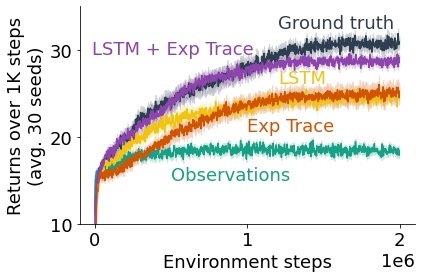

In [15]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(16, 35)
ax.set_xticks([0, 1e6, 2e6])
ax.set_yticks([10, 20, 30])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(5e5, 15, "Observations", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
plt.text(1e6, 20.7, "Exp Trace", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_0.95']['color'], fontdict=dict(size=18))
plt.text(1.2e6, 26.2, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
plt.text(-0.2e5, 29.5, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_0.95']['color'], fontdict=dict(size=18))
plt.text(1.2e6, 32.5, "Ground truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))


ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns over 1K steps\n(avg. 30 seeds)")
# ax.yaxis.set_label_coords(-0.12, 0.65)

# ax.set_title(f'Offline returns over environment steps (map #4, slip_prob = 0.1)')
# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

fig.savefig(fig_path, bbox_inches='tight')


In [20]:
data.shape

(30, 1000)

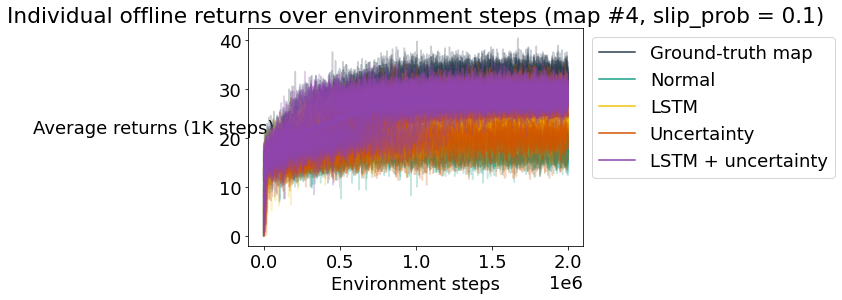

In [17]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)
    
    for d in data:
        ax.plot(x, d, color=color, alpha=0.25)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Individual offline returns over environment steps (map #4, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [ ]:
# here we perform our ablation WITHOUT a replay buffer.


In [29]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [30]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=100)


In [31]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf4m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=1),
  29.5152,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/17f528524abf170dd25d4f4708118710_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/d696d14541855f948faf23bb4a322b2c_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/b56ae1458f3ea89852468ccdedf270ee_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/f9aad7974312938defcff26276ec7ac0_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/bfbc01300efbc246a50950df6a8b7b98_Fri May 13 10:03:27 2022.npy')]),
 'uf4m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5),
  27.530399999999997,
  

In [32]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


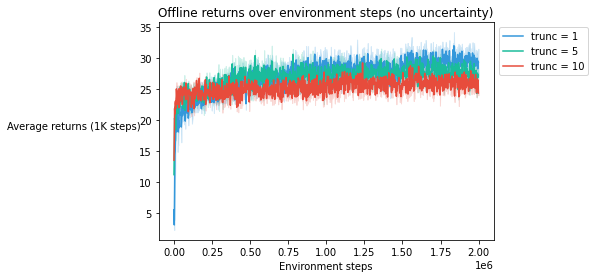

In [33]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


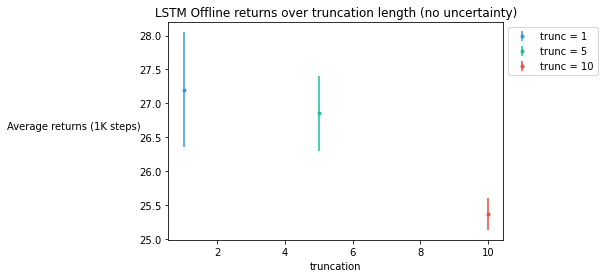

In [35]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

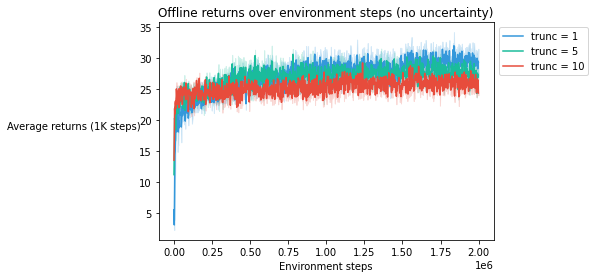

In [36]:
plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [37]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf4m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=1),
  34.2084,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/35f2f80e978f67bf98ddb4f6809a31ee_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/24e599690444fc62f773b0b5ccb20310_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/e6941f5e7a096f929f96e19b19aabb29_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/b1d00661945344032a5e2c4404e0cb6d_Fri May 13 10:03:27 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf4m_cnn_lstm/cc5813f240bbb881e5810e0cbb66dbc2_Fri May 13 10:11:34 2022.npy')]),
 'uf4m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-05, arch='cnn_lstm', uncertainty_decay=0.85, slip_prob=0.1, trunc=5),
  30.342399999999998,


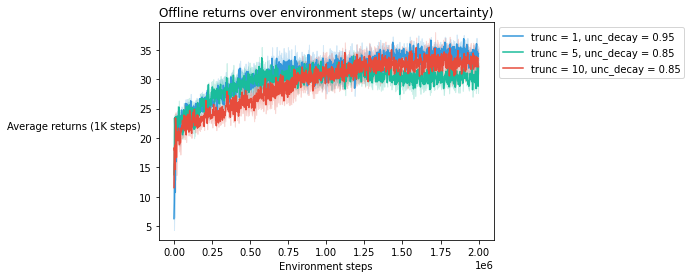

In [42]:
# with trunc
plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
}

fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [32.4288 30.7936 31.7584 28.1734 32.0292]
k: 5, step_means: [29.3452 28.6504 28.7054 29.9872 30.9234]
k: 10, step_means: [30.5304 32.1474 27.2166 31.178  25.8312]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_31792/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


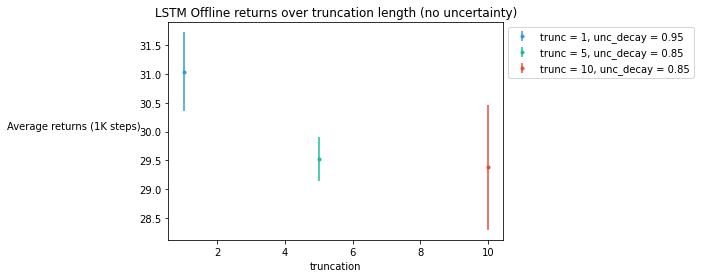

In [44]:
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')